In [63]:
import numpy as np
from tqdm import tqdm
import gym
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
env = gym.make('Taxi-v3')
num_actions = env.action_space
num_obs = env.observation_space
R, G, B, Y = env.unwrapped.locs
R, G, B, Y = list(R), list(G), list(B), list(Y)
env.reset()


(474, {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 1, 0], dtype=int8)})

In [65]:
def get_state(state):
    row, col, pass_id, dest_id = env.unwrapped.decode(state)
    state = np.asarray([row,col,pass_id,dest_id])
    return state

#encoding a 5x5 matrix as a 25x1 vector
def encode(pose):
    [row,col] = pose
    state_num = row * 5 + col
    return state_num

def decode(state_num):
    row = state_num // 5
    col = state_num % 5
    return row, col

print(R,G,B,Y)

[0, 0] [0, 4] [4, 0] [4, 3]


In [66]:
curr_state = get_state(env.s)
print("Taxi at",curr_state)
next_state, reward, done, _, _ = env.step(4)
row, col, pass_id, dest_id = env.unwrapped.decode(next_state)

Taxi at [4 3 3 2]


c:\Users\anike\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [67]:
def choose_action(state,qs,eps):
    #print(np.shape(q))
    length = np.shape(qs)[1]
    if not qs[state].any():
        return random.randint(0,length-1)
    action = np.argmax(qs[state])
    
    if np.random.rand() < eps:
        action = np.random.randint(0,length-1)
        return action
    return action   

def choose_action_option(state,qs):
    action = np.argmax(qs[state])
    return action  

In [68]:
# Options where policy is greedy wrt the corresponding q Value function
def Red(q_r,state,eps):
    optdone = False
    optact = choose_action(state,q_r,eps)
    state = decode(state)
    if state[0] == R[0] and state[1] == R[1]:
        optdone = True
    return optact,optdone

def Green(q_g,state,eps):
    optdone = False
    optact = choose_action(state,q_g,eps)
    state = decode(state)
    if state[0] == G[0] and state[1] == G[1]:
        optdone = True
    return optact,optdone
    
def Yellow(q_y,state,eps):
    optdone = False
    optact = choose_action(state,q_y,eps)
    state = decode(state)
    if state[0] == Y[0] and state[1] == Y[1]:
        optdone = True
    return optact,optdone 

def Blue(q_b,state,eps):
    optdone = False
    optact = choose_action(state,q_b,eps)
    state = decode(state)
    if state[0] == B[0] and state[1] == B[1]:
        optdone = True
    return optact,optdone 

In [69]:
Q_opt = np.zeros((4,25,4))
q = np.zeros((500,10))
qf = np.zeros((500,10))
qof = np.zeros((4,25,4))

### Hardcoded policy

In [70]:


policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ]).flatten()

policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ]).flatten()

policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ]).flatten()

policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ]).flatten()

policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]
for index1, value1 in enumerate(policyOpt):
   for index2, value2  in enumerate(value1):
      Q_opt[index1][index2][value2] = 1
#print(Q_opt)


### SMDP

In [71]:
# Set the number of episodes and maximum number of steps per episode
EPS = 10000
MAX_STEPS = 500
EXP = 1
# Set the learning rate, discount factor, and exploration rate
ALPHA1 = 0.1
ALPHA2 = 0.1
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

In [72]:
q = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

class SMDP:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def reset(self):
        q = np.zeros((500,10))
    qf = np.zeros((500,10))
    Q_opt = np.zeros((4,25,4))
    qof = np.zeros((4,25,4))


    def Qlearn(self,psuedo=False):
        for episode in tqdm(range(3000)):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(state,q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    q[state,action] = q[state, action] + ALPHA1 * (reward + GAMMA * np.max(q[next_state, :])- q[state, action])
                    qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 
                    epsilon = 0.2
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[0][next])- Q_opt[0][state, optact])
                            else:
                                Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[0][next, :])- Q_opt[0][state, optact])
                            qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[1][next])- Q_opt[1][state, optact])
                            else:
                                Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[1][next, :])- Q_opt[1][state, optact])
                            qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[2][next])- Q_opt[2][state, optact])
                            else:
                                Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[2][next, :])- Q_opt[2][state, optact])
                            qof[2][state,optact] += 1

                        if action == 9:

                            optact, optdone = Yellow(Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            else:
                                Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        if optdone == True:
                            q[current_state, action] += ALPHA1 * (reward_bar - q[current_state, action] + (GAMMA**count) * np.max(q[next_state, :]))
                            state = env.s
                        
            running = 0.05 * ep_reward + (1 - 0.05) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            #print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=0.71, color='blue')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break

    def plot_Q(self):
     actions = ["south", "north", "east", "west"]
     ACTIONS = ["R", "G", "Y", "B"]
     fig, axes = plt.subplots(1, len(qof), figsize=(16, 4)) 
     fig.suptitle('Frequency Map with best action for each state')
     for ax, q_value,k in zip(axes, qof, ACTIONS):
        q_plot = np.zeros((5, 5, 4))
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                q_plot[i, j] = q_value[state_num]

        ax.set_title(f"Option {k}")
        ax.pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar(ax.pcolor(q_plot.max(-1)), ax=ax)
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                anno = actions[np.argmax(q_plot[i, j])][0]
                size = 'large'
                ax.text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
        ax.invert_yaxis()

        

Learning Options Without Psuedo-Reward

100%|██████████| 3000/3000 [00:15<00:00, 193.56it/s]


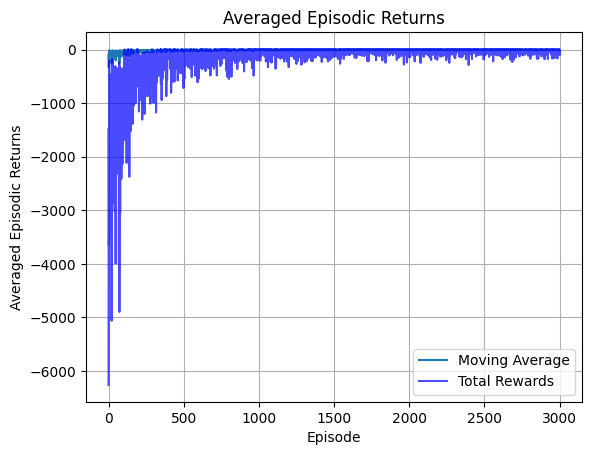

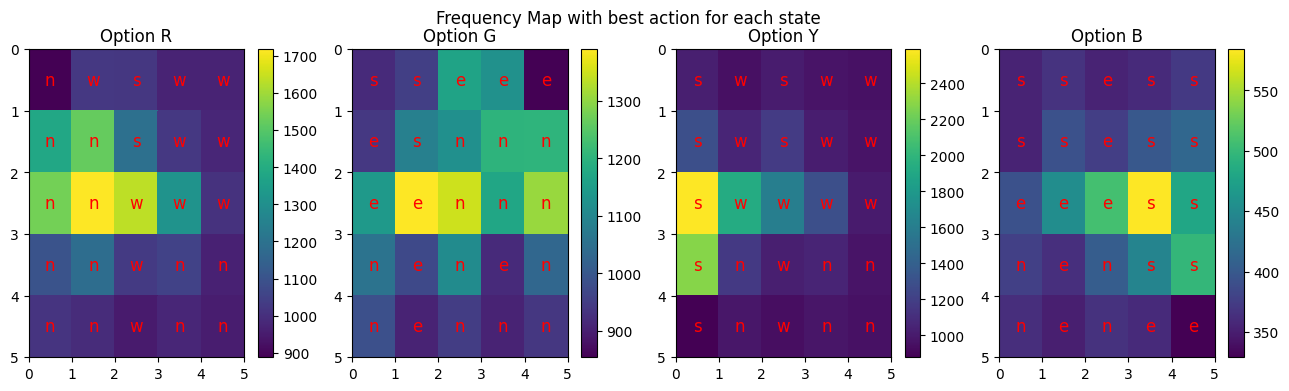

In [73]:
smdp = SMDP()
smdp.Qlearn(psuedo=False)
smdp.plot()
smdp.plot_Q()

Learning Options with Psuedo-Reward

100%|██████████| 3000/3000 [00:01<00:00, 1847.10it/s]


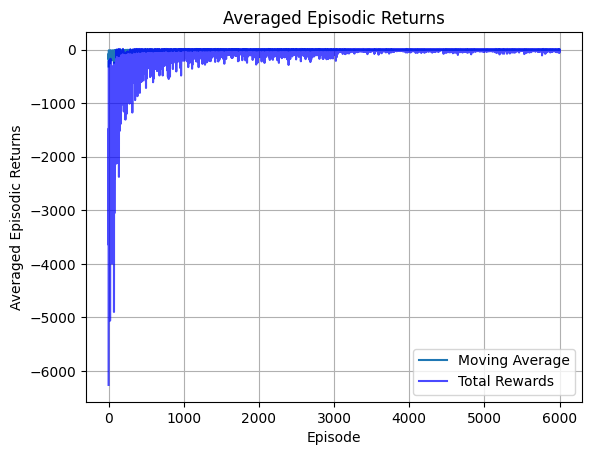

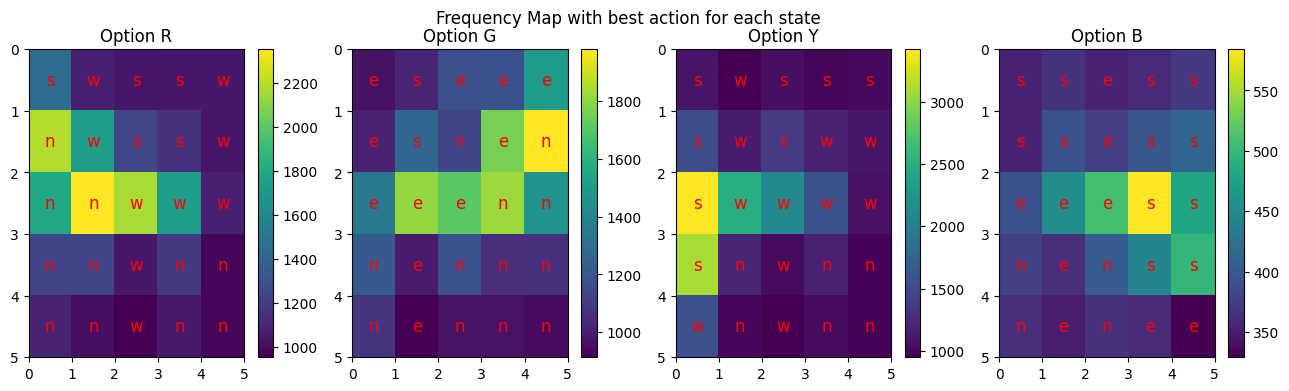

In [74]:
smdp.reset()
smdp.Qlearn(psuedo=True)
smdp.plot()
smdp.plot_Q()


### INTRA OPTION

In [75]:
q_intra = np.zeros((500,10))
qf = np.zeros((500,10))
qof = np.zeros((4,25,4))

In [76]:
class INTRAOPT:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def Qlearn(self):
        epsilon = 0.1
        for episode in range(5000):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                state = env.s
                action = choose_action(state,q_intra,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    q_intra[state,action] = q_intra[state, action] + ALPHA1 * (reward + GAMMA * np.max(q_intra[next_state, :])- q_intra[state, action])
                    qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 

                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[0][next, :])- Q_opt[0][state, optact])
                            qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[1][next, :])- Q_opt[1][state, optact])
                            qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[2][next, :])- Q_opt[2][state, optact])
                            qof[2][state,optact] += 1

                        if action == 9:

                            optact, optdone = Yellow(Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        statey = env.s
                        q_intra[statey, action] += ALPHA1 * (reward_bar - q_intra[statey, action] + (GAMMA**count) * np.max(q_intra[statey, :]))
                        
                        
                if epsilon > 0.01:
                    epsilon = epsilon*np.exp(-0.01)
            running = 0.35 * ep_reward + (1 - 0.35) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=1, color='orange')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break

    def plot_Q(self):
        ACTIONS = {0: "South",1: "Up",2: "East",3: "West",4: "Pick",5: "Drop",6: "R",7: "G",8: "B", 9: "Y"}
        # decode each state 
        # ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
        action = np.argmax(q,axis=1)
        action_f = np.argmax(qf,axis=1)

        dest_r = action[::4]
        dest_g = action[1::4]
        dest_b = action[2::4]
        dest_y = action[3::4]

        dest_r_f = action_f[::4]
        dest_g_f = action_f[1::4]
        dest_b_f = action_f[2::4]
        dest_y_f = action_f[3::4]

        loc_r_r = dest_r[::5]
        loc_r_g = dest_g[::5]
        loc_r_b = dest_b[::5]
        loc_r_y = dest_y[::5]

        loc_r_r_f = dest_r_f[::5]
        loc_r_g_f = dest_g_f[::5]
        loc_r_b_f = dest_b_f[::5]
        loc_r_y_f = dest_y_f[::5]

        loc_g_r = dest_r[1::5]
        loc_g_g = dest_g[1::5]
        loc_g_b = dest_b[1::5]
        loc_g_y = dest_y[1::5]

        loc_g_r_f = dest_r_f[1::5]
        loc_g_g_f = dest_g_f[1::5]
        loc_g_b_f = dest_b_f[1::5]
        loc_g_y_f = dest_y_f[1::5]

        loc_b_r = dest_r[2::5]
        loc_b_g = dest_g[2::5]
        loc_b_b = dest_b[2::5]
        loc_b_y = dest_y[2::5]

        loc_b_r_f = dest_r_f[2::5]
        loc_b_g_f = dest_g_f[2::5]
        loc_b_b_f = dest_b_f[2::5]
        loc_b_y_f = dest_y_f[2::5]

        loc_y_r = dest_r[3::5]
        loc_y_g = dest_g[3::5]
        loc_y_b = dest_b[3::5]
        loc_y_y = dest_y[3::5]

        loc_y_r_f = dest_r_f[3::5]
        loc_y_g_f = dest_g_f[3::5]
        loc_y_b_f = dest_b_f[3::5]
        loc_y_y_f = dest_y_f[3::5]

        action_o = np.argmax(Q_opt,axis=2)
        action_o_f = np.argmax(qof,axis=2)

        dest_r = action_o[0]
        dest_g = action_o[1]
        dest_b = action_o[2]
        dest_y = action_o[3]

        freq_r = action_o_f[0]
        freq_g = action_o_f[1]
        freq_b = action_o_f[2]
        freq_y = action_o_f[3]

        # Create a 5x5 grid for grid and frequncy
        grid = np.reshape(loc_r_g, (5, 5))
        freq = np.reshape(loc_r_g_f, (5, 5))

        # Create a 5x5 grid for grid and frequncy
        grid_dest = np.reshape(dest_r, (5, 5))
        freq_dest = np.reshape(freq_r, (5, 5))

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the grid with numbers for loc_r_g
        axs[0].imshow(freq, cmap='viridis', interpolation='nearest')
        for i in range(5):
            for j in range(5):
                text = ACTIONS[grid[i, j]]
                axs[0].text(j, i, text, ha='center', va='center', color='black')

        # Add labels and title for loc_r_g
        axs[0].set_title("Red passenger to dest Green q table")
        axs[0].set_xlabel('Column')
        axs[0].set_ylabel('Row')

        # Display the grid with numbers for dest_r
        axs[1].imshow(freq_dest, cmap='viridis', interpolation='nearest')
        for i in range(5):
            for j in range(5):
                text = ACTIONS[grid_dest[i, j]]
                axs[1].text(j, i, text, ha='center', va='center', color='black')

        # Add labels and title for dest_r
        axs[1].set_title("Red Option Policy")
        axs[1].set_xlabel('Column')
        axs[1].set_ylabel('Row')

        plt.tight_layout()
        plt.show()
        
        

Episode 1: Total Reward = -748.3
Episode 2: Total Reward = -17969.0
Episode 3: Total Reward = -4872.349999999999
Episode 4: Total Reward = -1676.5
Episode 5: Total Reward = -2569.7
Episode 6: Total Reward = -1015.6999999999999
Episode 7: Total Reward = -498.74999999999994
Episode 8: Total Reward = -1910.3
Episode 9: Total Reward = -8864.8
Episode 10: Total Reward = -1815.8
Episode 11: Total Reward = -21663.949999999997
Episode 12: Total Reward = -13552.0
Episode 13: Total Reward = -58.8
Episode 14: Total Reward = -482.65
Episode 15: Total Reward = -1346.1
Episode 16: Total Reward = -300.29999999999995
Episode 17: Total Reward = -739.9
Episode 18: Total Reward = -459.2
Episode 19: Total Reward = -328.29999999999995
Episode 20: Total Reward = -380.79999999999995
Episode 21: Total Reward = -212.1
Episode 22: Total Reward = -2010.7499999999998
Episode 23: Total Reward = -449.04999999999995
Episode 24: Total Reward = -1077.3
Episode 25: Total Reward = -97.64999999999999
Episode 26: Total Re

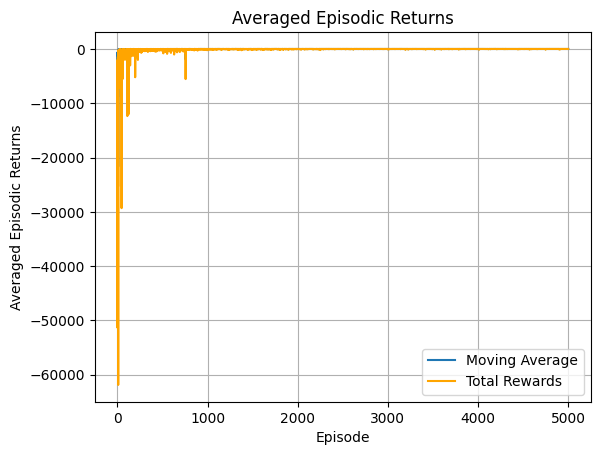

In [77]:
agent2 = INTRAOPT()
agent2.Qlearn()
agent2.plot()

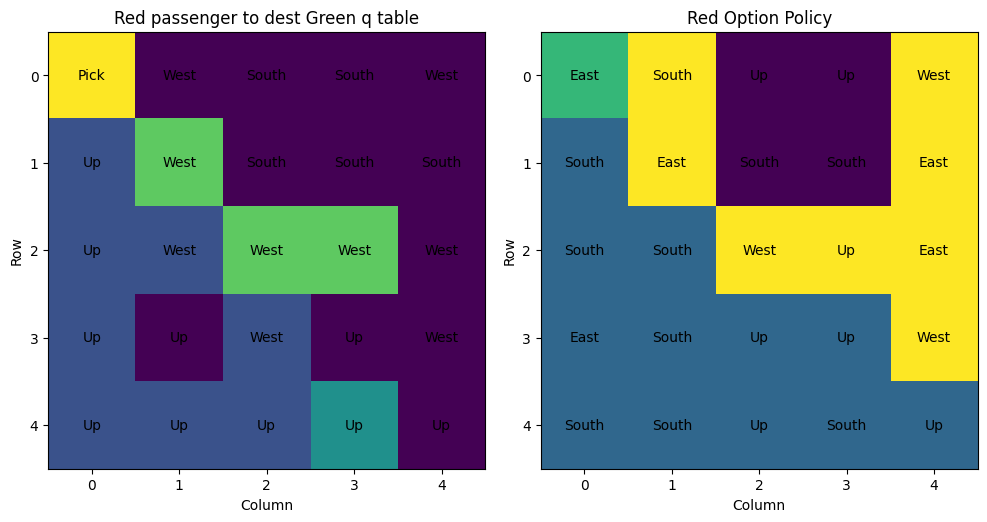

In [78]:
agent2.plot_Q()